# FSGAN

# setup

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time

import kagglehub
import utils
import dataloader

c:\dev\ProjetImage\Face-Swap-M2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  False


In [3]:
IMAGE_SIZE = 128
NB_IMAGES = 10

train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# CelebA

In [20]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

for root, dirs, files in os.walk(path):
    print(f"Dossier: {root}")
    print(f"Sous-dossiers: {dirs}")
    print(f"Fichiers (premiers 5): {files[:5]}")
    break

Path to dataset files: C:\Users\timothée\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2
Dossier: C:\Users\timothée\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2
Sous-dossiers: ['img_align_celeba']
Fichiers (premiers 5): ['list_attr_celeba.csv', 'list_bbox_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv']


In [21]:


from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
import random

# Définir les transformations pour redimensionner les images à 64x64
transform = Compose([
    Resize((128, 128)),  # Redimensionner les images à 64x64
    ToTensor(),        # Convertir en tenseur PyTorch
    Normalize((0.5,), (0.5,))  # Normaliser les pixels entre -1 et 1
])

# Charger le dataset complet
dataset_path = "C:\\Users\\timothée\\.cache\\kagglehub\\datasets\\jessicali9530\\celeba-dataset\\versions\\2"
human_faces_dataset = ImageFolder(root=dataset_path, transform=transform)

# Réduire à 10% du dataset
dataset_size = len(human_faces_dataset)
subset_size = int(0.05 * dataset_size)
indices = random.sample(range(dataset_size), subset_size)
subset_dataset = Subset(human_faces_dataset, indices)

# Diviser le sous-dataset en train/test
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Nombre d'images dans le sous-dataset : {len(subset_dataset)}")
print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")



Nombre d'images dans le sous-dataset : 10129
Nombre d'images dans le train set : 8103
Nombre d'images dans le test set : 2026


# Data Augmentation et parametres

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


In [5]:

EMBEDDING_SIZE = 64
BATCH_SIZE = 32

EPOCHS = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.929411768913269
Max pixel value: 1.0
Mean pixel value: 0.024877222254872322


In [22]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

train samples: 8103, test samples: 2026, nb_classes: 10


KeyboardInterrupt: 

# fsgan Segmentation

In [7]:
from fsgan.simple_unet_02 import UNet

model_path = "fsgan/weights/celeba_unet_256_1_2_segmentation_v2.pth"

weights = torch.load(model_path, map_location=device, weights_only=False)
state_dict = weights['state_dict'] if isinstance(weights, dict) and 'state_dict' in weights else weights
new_state = {} 
for k, v in state_dict.items(): 
    new_key = k[7:] if k.startswith('module.') else k 
    new_state[new_key] = v

num_classes = None
for k in new_state.keys():
    if k.endswith("final.weight") or k.endswith("final.conv.weight") or ("final" in k and k.endswith("weight")):
        num_classes = new_state[k].shape[0]
        break
if num_classes is None:
    print("NUM CLASSES NONE")
    num_classes = 1


segmentor = UNet(num_classes=num_classes).to(device)


segmentor.load_state_dict(new_state, strict=False)
segmentor.to(device)
segmentor.eval()
model_parameters = filter(lambda p: p.requires_grad, segmentor.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Segmentor has {params} parameters")


Segmentor has 28950851 parameters


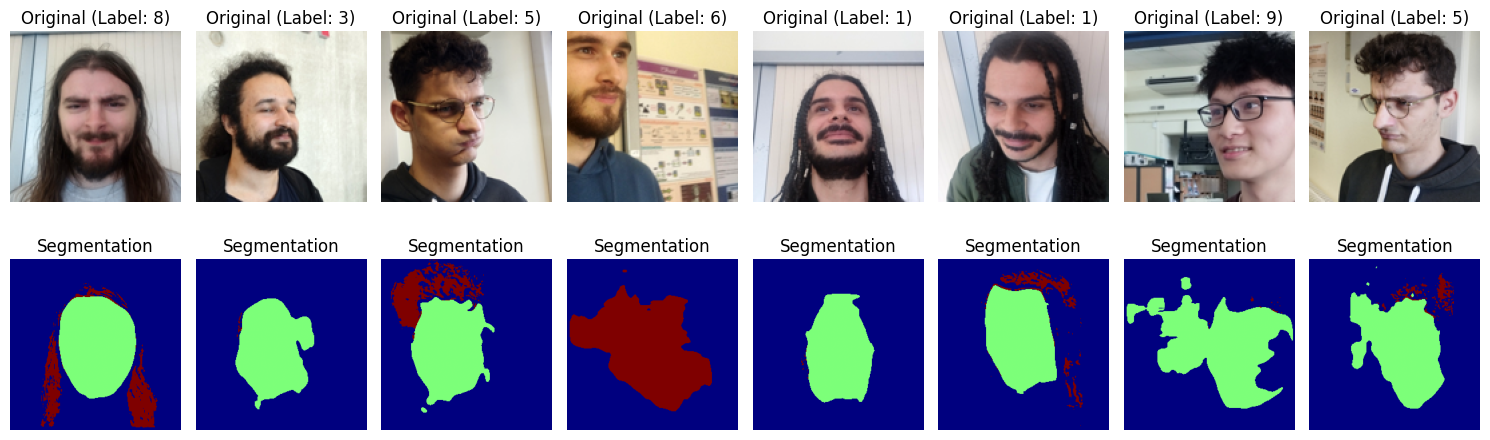

In [8]:
# Test the segmentor with a batch of images from the test_loader
images, labels = next(iter(test_loader))
images = images.to(device)

# Normalize the images for the segmentor
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
normalized_images = (images + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
normalized_images = (normalized_images - mean) / std

# Resize the images to the target size (512x512)
resized_images = F.interpolate(normalized_images, size=(256, 256), mode='bilinear', align_corners=False)

# Pass the resized images through the segmentor
with torch.no_grad():
    outputs = segmentor(resized_images)

    # Extract the segmentation logits
    seg_logits = outputs[0] if isinstance(outputs, (list, tuple)) else outputs

    # Get the segmentation map by taking the argmax
    seg_map = seg_logits.argmax(dim=1).cpu().numpy()

# Visualize the original images and their corresponding segmentation maps
n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    # Segmentation map
    axs[1, i].imshow(seg_map[i], cmap="jet")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

# FSGAN landmarks 

In [9]:
import os
import torch
from fsgan.hrnet import hrnet_wlfw

def strip_module_prefix(state_dict):
    new = {}
    for k, v in state_dict.items():
        new_k = k[7:] if k.startswith('module.') else k
        new[new_k] = v
    return new

def load_hr18_landmarks(model_path, device=None, strict=True):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    device = torch.device("cuda" if torch.cuda.is_available() and (device is None or str(device).startswith("cuda")) else "cpu") \
             if device is None else torch.device(device)

    # instantiate model
    model = hrnet_wlfw().to(device)

    # load checkpoint
    ckpt = torch.load(model_path, map_location=device)

    # extract state_dict whether ckpt is { 'state_dict': ... } or a raw state_dict
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    # sometimes keys are saved with "module." prefix
    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = strip_module_prefix(state_dict)

    # try loading (fallback to strict=False on failure)
    try:
        model.load_state_dict(state_dict, strict=strict)
    except RuntimeError as e:
        # try again with strict=False to allow minor mismatches
        print("Strict load failed, retrying with strict=False. Error:", e)
        model.load_state_dict(state_dict, strict=False)

    model.eval()
    return model

# Example usage:
# model = load_hr18_landmarks("weights/hr18_wflw_landmarks.pth")
# print(model)

In [36]:
model_path = "weights/hr18_wflw_landmarks.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pass the path as pretrained so model.init_weights will load keys that match
kpdetector = hrnet_wlfw(pretrained=model_path)
kpdetector.eval()

HighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (sf): Softmax(dim=1)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=Tr

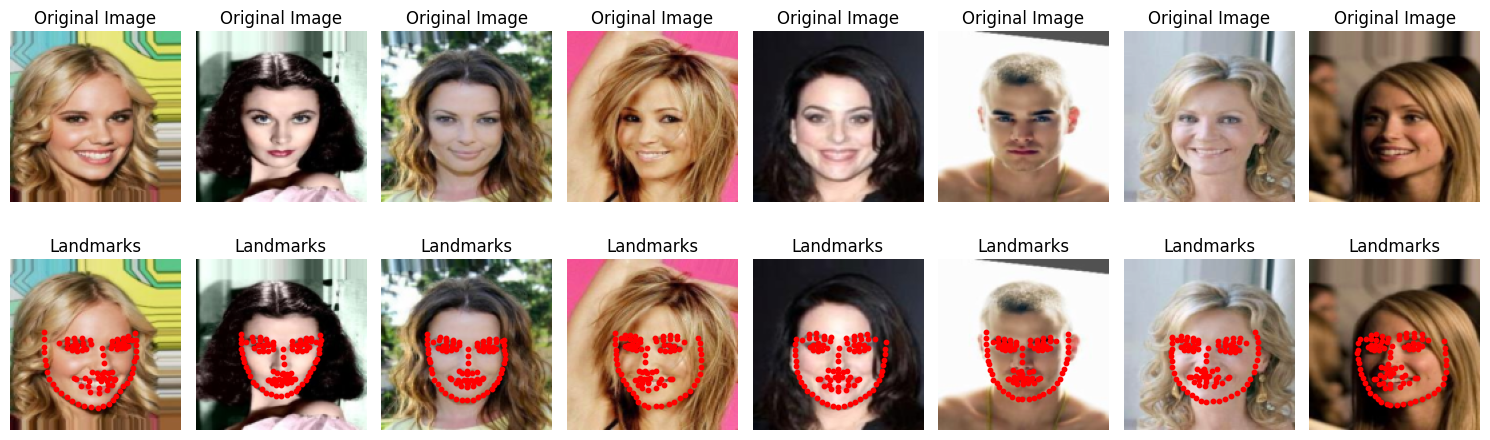

In [37]:
import torch
import torch.nn.functional as F
from fsgan.hrnet import hrnet_wlfw            # correct import
from fsgan.landmarks_utils import LandmarksHeatMapEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model + weights
kpdetector = hrnet_wlfw().to(device).eval()
state = torch.load('fsgan/weights/hr18_wflw_landmarks.pth', map_location=device)
if isinstance(state, dict) and 'state_dict' in state: state = state['state_dict']
state = {k[7:]: v for k, v in state.items()} if next(iter(state)).startswith('module.') else state
kpdetector.load_state_dict(state, strict=False)

# batch
images, _ = next(iter(test_loader))         # images in [-1,1] or [0,1]
images = images.to(device)

# preprocess for HRNet: 256 and ImageNet norm
imgs = images
if imgs.min() < 0:                          # if in [-1,1], bring to [0,1]
    imgs = (imgs + 1.0) / 2.0
mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
imgs = F.interpolate(imgs, size=(256,256), mode='bilinear', align_corners=False)
imgs = (imgs - mean) / std

# forward
with torch.no_grad():
    H = kpdetector(imgs)                         # (B,98,64,64) heatmaps
    enc = LandmarksHeatMapEncoder(size=H.shape[-1]).to(device)
    L = enc(H)                              # (B,98,2) in [0,1]
    # fallback if encoder zeroes out
    flat = H.view(H.shape[0], H.shape[1], -1); idx = flat.argmax(2)
    xs_arg = (idx % H.shape[-1]).float() / H.shape[-1]
    ys_arg = (idx // H.shape[-1]).float() / H.shape[-1]
    deg = ((H.view(H.shape[0], H.shape[1], -1).max(-1).values - H.view(H.shape[0], H.shape[1], -1).min(-1).values) < 1e-5)
    if deg.any():
        b, c = deg.nonzero(as_tuple=True)
        L[b, c, 0] = xs_arg[b, c]; L[b, c, 1] = ys_arg[b, c]

# L now contains valid normalized landmark coords (multiply by 256 for pixels)

# Visualize the results
n = min(8, images.size(0))  # Number of images to display
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original Image")
    axs[0, i].axis("off")

    # Landmarks
    landmarks = L[i].cpu().numpy() * 128  # Scale normalized coords to pixel values
    axs[1, i].imshow(img_disp)
    axs[1, i].scatter(landmarks[:, 0], landmarks[:, 1], c="red", s=10)
    axs[1, i].set_title("Landmarks")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

# FSGAN reenactment

In [25]:
import torch
from fsgan.res_unet_split import MultiScaleResUNet

def load_msrunet_split(weights_path, device):
    ckpt = torch.load(weights_path, map_location=device)
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    # Retirer éventuel préfixe 'module.'
    cleaned = {}
    for k,v in state_dict.items():
        nk = k[7:] if k.startswith('module.') else k
        cleaned[nk] = v

    # Déterminer nombre d'enhancers
    n_local = 0
    while True:
        n_local += 1
        key_probe = f'enhancer{n_local}.in_conv.1.weight'
        if key_probe not in cleaned:
            n_local -= 1
            break
    if n_local == 0:
        n_local = 1

    # Déterminer in_nc à partir du premier conv d'entrée
    base_in_weight_key = None
    for k in cleaned.keys():
        if k.endswith('in_conv.1.weight') and k.startswith('base'):
            base_in_weight_key = k
            break
    if base_in_weight_key is None:
        for k in cleaned.keys():
            if k.endswith('.weight') and cleaned[k].dim() == 4:
                base_in_weight_key = k
                break
    in_nc = cleaned[base_in_weight_key].shape[1]

    # Déterminer ngf
    ngf = 64
    enhancer_key = f'enhancer1.in_conv.1.weight' if n_local > 0 else None
    if enhancer_key and enhancer_key in cleaned:
        ngf = cleaned[enhancer_key].shape[0]
    else:
        base_first_conv_out = cleaned['base.in_conv.1.weight'].shape[0]
        ngf = base_first_conv_out // (2 ** n_local) if n_local > 0 else base_first_conv_out

    # Déterminer out_nc - VERSION SPLIT: tuple de sorties
    # Compter le nombre de têtes de sortie (out_conv1, out_conv2, etc.)
    num_heads = 0
    for k in cleaned.keys():
        if k.startswith('base.out_conv') and k.endswith('.0.weight'):
            num_heads += 1
    
    # Si aucune tête trouvée, par défaut 1 tête avec 3 canaux
    if num_heads == 0:
        num_heads = 1
    
    # Récupérer le nombre de canaux de chaque tête
    out_nc = []
    for i in range(1, num_heads + 1):
        key = f'base.out_conv{i}.0.weight'
        if key in cleaned:
            out_nc.append(cleaned[key].shape[0])
        else:
            out_nc.append(3)  # Par défaut 3 canaux RGB
    
    out_nc = tuple(out_nc)
    
    # Instancier modèle avec les bons paramètres
    model = MultiScaleResUNet(
        in_nc=in_nc, 
        out_nc=out_nc,  # Tuple au lieu d'un seul int
        ngf=ngf,
        n_local_enhancers=n_local
    ).to(device)
    
    model.load_state_dict(cleaned, strict=False)
    model.eval()
    print(f"Loaded MultiScaleResUNet (split): in_nc={in_nc}, out_nc={out_nc}, ngf={ngf}, enhancers={n_local}, heads={len(out_nc)}")
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reenactment_weights = "fsgan/weights/nfv_msrunet_256_1_2_reenactment_v2.1.pth"
reenactment_model = load_msrunet_split(reenactment_weights, device)

Loaded MultiScaleResUNet (split): in_nc=101, out_nc=(3,), ngf=128, enhancers=1, heads=1


In [ ]:
# inspecte l'architecture
print(reenactment_model)

# inspecte le premier conv (attendu : shape = (out_channels, in_channels, k, k))
sd = reenactment_model.state_dict()
for k,v in sd.items():
    if 'in_conv' in k and k.endswith('.weight'):
        print("first input conv:", k, v.shape)
        break

# lister les out_conv pour voir les têtes et leurs canaux
for k,v in sd.items():
    if 'out_conv' in k and k.endswith('.weight'):
        print(k, v.shape)
        


MultiScaleResUNet(
  (base): ResUNet(
    (in_conv): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(101, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (out_conv1): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(256, 3, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): Tanh()
    )
    (inner): SkipConnectionBlock(
      (submodule): SkipConnectionBlock(
        (submodule): SkipConnectionBlock(
          (flat_block): FlatBlock(
            (model): Sequential(
              (0): ResnetBlock(
                (model): Sequential(
                  (0): ReflectionPad2d((1, 1, 1, 1))
                  (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
                  (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (3): R

[Pair 0] raw_heatmaps.shape = torch.Size([1, 98, 64, 64]), range=[-0.072, 0.958]
[Pair 0] heatmaps for gen: shape=torch.Size([1, 98, 256, 256]), range=[-1.487, 10.000]
[Pair 0] gen_input.shape = torch.Size([1, 101, 256, 256]), src range=[-1.000, 0.908]
[Pair 0] Generator outputs:
  out[0].shape=torch.Size([1, 3, 256, 256]), range=[-1.000, 1.000]
[Pair 1] raw_heatmaps.shape = torch.Size([1, 98, 64, 64]), range=[-0.065, 0.950]
[Pair 1] heatmaps for gen: shape=torch.Size([1, 98, 256, 256]), range=[-0.918, 10.000]
[Pair 1] gen_input.shape = torch.Size([1, 101, 256, 256]), src range=[-0.999, 1.000]
[Pair 1] Generator outputs:
  out[0].shape=torch.Size([1, 3, 256, 256]), range=[-1.000, 1.000]
[Pair 2] raw_heatmaps.shape = torch.Size([1, 98, 64, 64]), range=[-0.057, 1.043]
[Pair 2] heatmaps for gen: shape=torch.Size([1, 98, 256, 256]), range=[-0.742, 10.000]
[Pair 2] gen_input.shape = torch.Size([1, 101, 256, 256]), src range=[-1.000, 1.000]
[Pair 2] Generator outputs:
  out[0].shape=torch.Si

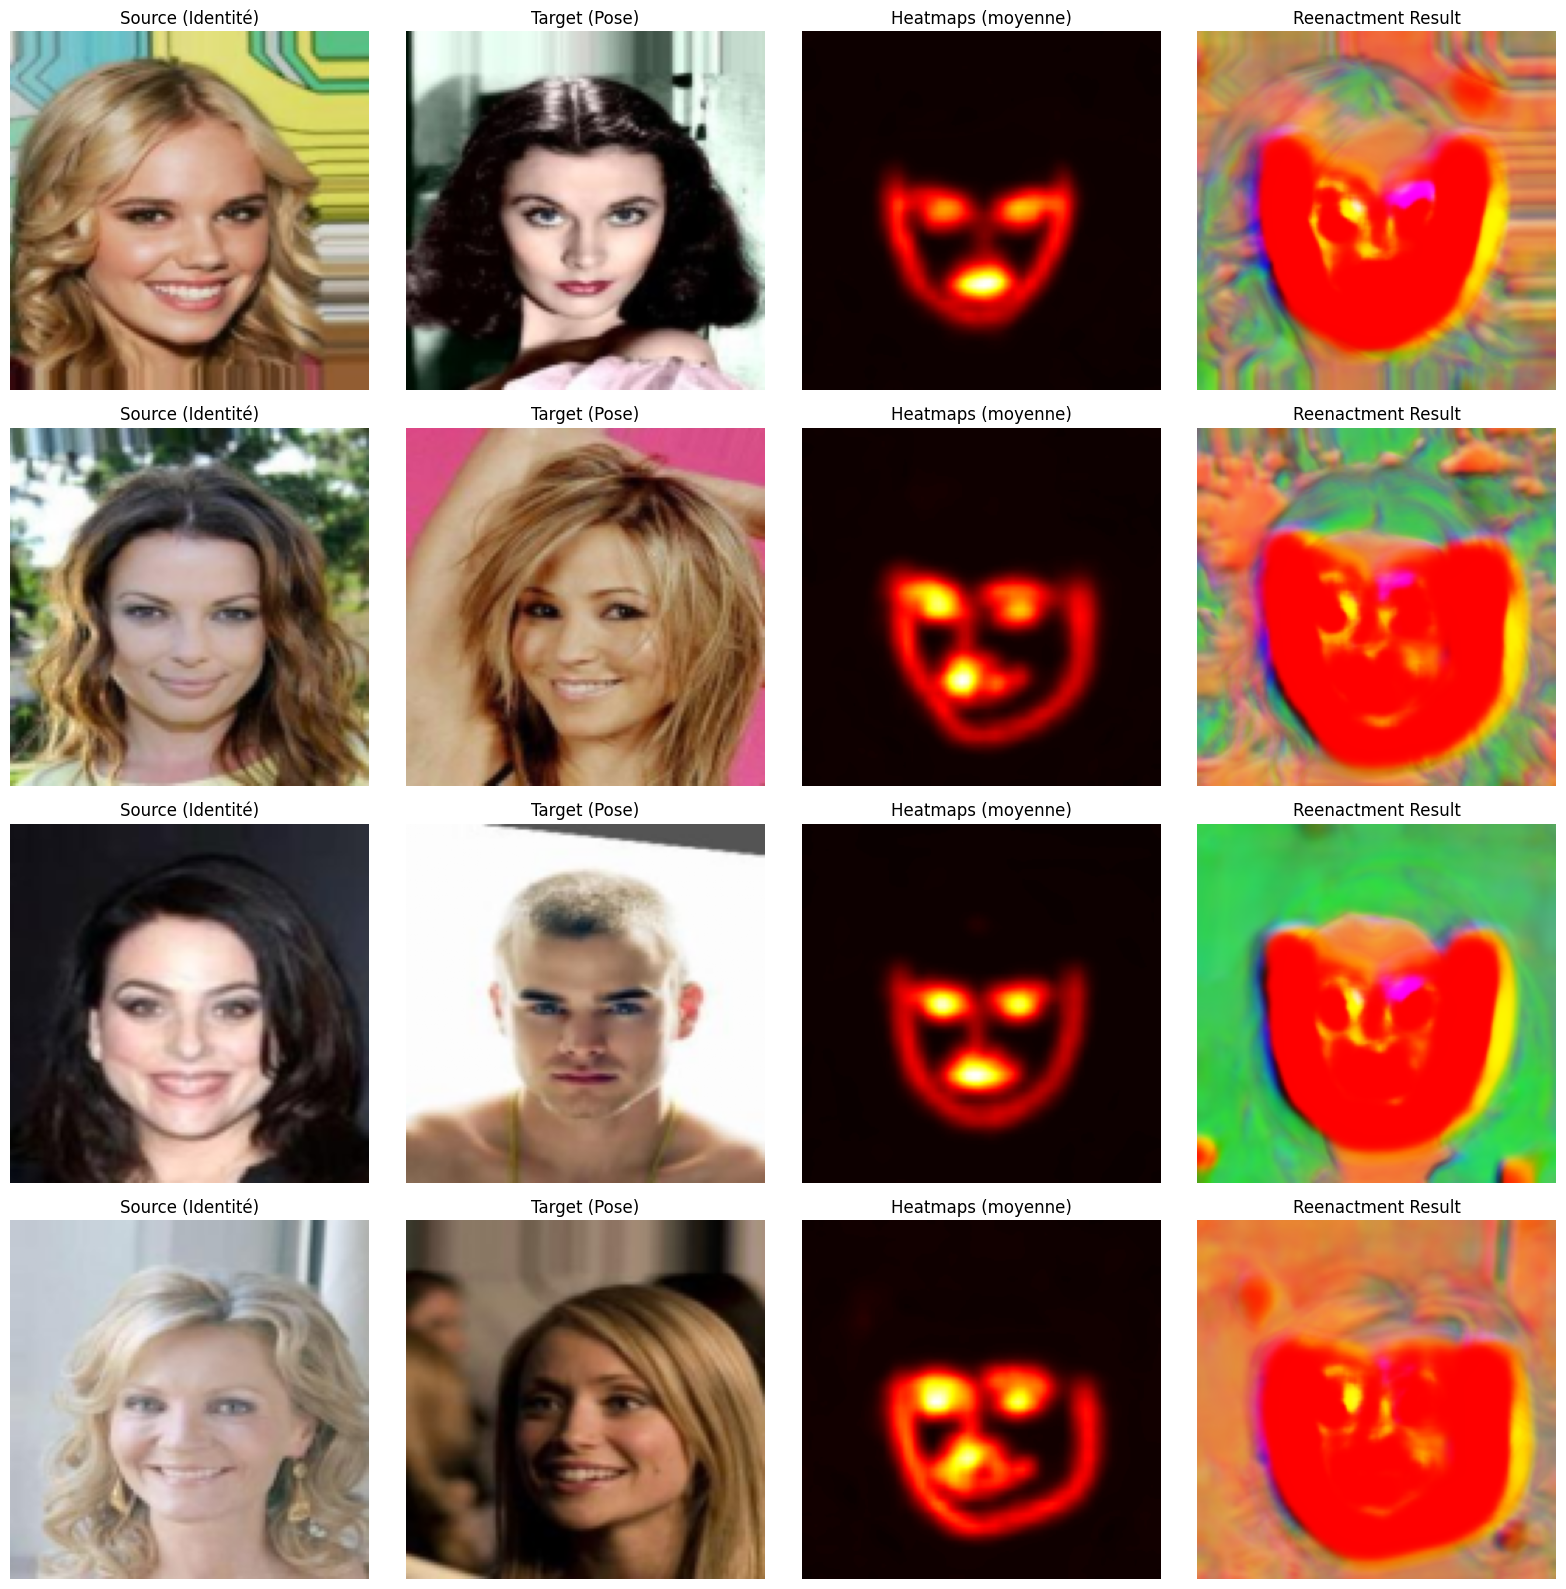


Test terminé avec 4 paires. Paramètres: HEATMAP_SCALE=10.0, UPSAMPLE_TO=(256, 256)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURABLE ---
HEATMAP_SCALE = 1.0
UPSAMPLE_TO = (256, 256)
SWAP_RGB = False
N_PAIRS = 4
SHOW_HEATMAPS = False  # Désactiver pour voir plus clairement les résultats
# ----------------------

def extract_heatmaps(detector_out):
    if isinstance(detector_out, torch.Tensor):
        return detector_out
    if isinstance(detector_out, (tuple, list)):
        for x in detector_out:
            if isinstance(x, torch.Tensor) and x.dim() == 4:
                if 5 <= x.shape[1] <= 300:
                    return x
        for x in detector_out:
            if isinstance(x, torch.Tensor) and x.dim() == 4:
                return x
    if isinstance(detector_out, dict):
        for v in detector_out.values():
            if isinstance(v, torch.Tensor) and v.dim() == 4:
                return v
    raise RuntimeError("Impossible d'extraire les heatmaps depuis la sortie du détecteur.")

def prepare_heatmaps_for_generator(raw_heatmaps, target_size=UPSAMPLE_TO, scale=HEATMAP_SCALE, to_minus1_1=False):
    if raw_heatmaps.shape[2:] != target_size:
        hm = F.interpolate(raw_heatmaps, size=target_size, mode='bilinear', align_corners=False)
    else:
        hm = raw_heatmaps

    b, k, h, w = hm.shape
    hm_flat = hm.view(b, k, -1)
    hm_max = hm_flat.max(dim=2)[0].view(b, k, 1, 1)
    hm = hm / (hm_max + 1e-8)
    hm = hm * float(scale)

    if to_minus1_1:
        hm = hm * 2.0 - 1.0

    return hm

def find_rgb_head_from_outputs(outs):
    if isinstance(outs, torch.Tensor):
        return outs, [outs]
    outs_list = list(outs)
    rgb = None
    for o in outs_list:
        if isinstance(o, torch.Tensor) and o.dim() == 4 and o.shape[1] == 3:
            rgb = o
            break
    if rgb is None:
        for o in outs_list:
            if isinstance(o, torch.Tensor) and o.dim() == 4:
                rgb = o
                break
    return rgb, outs_list

# Récupérer un batch
batch_images, _ = next(iter(test_loader))
batch_images = batch_images.to(device)

# Nombre de paires
n_pairs = min(N_PAIRS, batch_images.size(0) // 2)
fig, axs = plt.subplots(n_pairs, 4, figsize=(16, 4 * n_pairs))
if n_pairs == 1:
    axs = axs.reshape(1, -1)

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

for idx in range(n_pairs):
    # Source et Target - DÉJÀ EN [-1, 1] depuis le dataloader
    src = batch_images[idx * 2:idx * 2 + 1]
    tgt = batch_images[idx * 2 + 1:idx * 2 + 2]

    # Pour affichage: convertir en [0,1]
    src_disp = torch.clamp((src + 1.0) / 2.0, 0, 1)[0].permute(1, 2, 0).cpu().numpy()
    tgt_disp = torch.clamp((tgt + 1.0) / 2.0, 0, 1)[0].permute(1, 2, 0).cpu().numpy()

    # Redimensionner à 256x256
    src_256 = F.interpolate(src, size=UPSAMPLE_TO, mode='bilinear', align_corners=False)
    tgt_256 = F.interpolate(tgt, size=UPSAMPLE_TO, mode='bilinear', align_corners=False)

    # ⚠️ CORRECTION : src_256 est DÉJÀ en [-1,1], pas besoin de conversion
    # Juste pour le détecteur, on convertit target en [0,1] puis normalise ImageNet
    tgt_01 = (tgt_256 + 1.0) / 2.0  # [-1,1] -> [0,1]
    tgt_prep = (tgt_01 - mean) / std

    # Extraire heatmaps
    with torch.no_grad():
        det_out = kpdetector(tgt_prep)
    raw_heatmaps = extract_heatmaps(det_out)

    print(f"[Pair {idx}] raw_heatmaps.shape = {raw_heatmaps.shape}, range=[{raw_heatmaps.min():.3f}, {raw_heatmaps.max():.3f}]")

    # Préparer heatmaps
    hm_for_gen = prepare_heatmaps_for_generator(raw_heatmaps, target_size=UPSAMPLE_TO, scale=HEATMAP_SCALE, to_minus1_1=False)

    print(f"[Pair {idx}] heatmaps for gen: shape={hm_for_gen.shape}, range=[{hm_for_gen.min():.3f}, {hm_for_gen.max():.3f}]")

    # ✅ CORRECTION : src_256 est déjà en [-1,1], on concatène directement
    gen_input = torch.cat([src_256, hm_for_gen.to(device)], dim=1)
    print(f"[Pair {idx}] gen_input.shape = {gen_input.shape}, src range=[{src_256.min():.3f}, {src_256.max():.3f}]")

    # Forward
    with torch.no_grad():
        outs = reenactment_model(gen_input)

    rgb_out, outs_list = find_rgb_head_from_outputs(outs)
    if rgb_out is None:
        raise RuntimeError("Impossible de trouver une sortie RGB.")

    print(f"[Pair {idx}] Generator outputs:")
    for j, o in enumerate(outs_list):
        if isinstance(o, torch.Tensor):
            print(f"  out[{j}].shape={o.shape}, range=[{o.min():.3f}, {o.max():.3f}]")

    # Post-process RGB
    result = rgb_out
    result_disp = torch.clamp((result[0] + 1.0) / 2.0, 0, 1).permute(1, 2, 0).cpu().numpy()

    if SWAP_RGB:
        result_disp = result_disp[..., ::-1]

    # Affichage
    axs[idx, 0].imshow(src_disp)
    axs[idx, 0].set_title("Source (Identité)")
    axs[idx, 0].axis("off")

    axs[idx, 1].imshow(tgt_disp)
    axs[idx, 1].set_title("Target (Pose)")
    axs[idx, 1].axis("off")

    heatmap_mean = hm_for_gen[0].mean(dim=0).cpu().numpy()
    axs[idx, 2].imshow(heatmap_mean, cmap='hot')
    axs[idx, 2].set_title("Heatmaps (moyenne)")
    axs[idx, 2].axis("off")

    axs[idx, 3].imshow(result_disp)
    axs[idx, 3].set_title("Reenactment Result")
    axs[idx, 3].axis("off")

plt.tight_layout()
plt.show()

print(f"\nTest terminé avec {n_pairs} paires. Paramètres: HEATMAP_SCALE={HEATMAP_SCALE}, UPSAMPLE_TO={UPSAMPLE_TO}")